In [38]:
import numpy as np
import pandas as pd           # ← This line is REQUIRED
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

In [29]:
# Load dataset
df = pd.read_csv("agro_dataset_multi_market.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Display dataset info
print("✅ Dataset Loaded Successfully!")
print(df.head())
print(df.info())
print(df.describe())



✅ Dataset Loaded Successfully!
        date commodity market  modal_price  arrivals
0 2020-01-01    Tomato   Pune      2428.69     88.02
1 2020-01-02    Tomato   Pune      2223.15    137.60
2 2020-01-03    Tomato   Pune      2358.97     86.11
3 2020-01-04    Tomato   Pune      2267.53     97.52
4 2020-01-05    Tomato   Pune      2319.28    104.09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65772 entries, 0 to 65771
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         65772 non-null  datetime64[ns]
 1   commodity    65772 non-null  object        
 2   market       65772 non-null  object        
 3   modal_price  65772 non-null  float64       
 4   arrivals     65772 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 2.5+ MB
None
                                date   modal_price      arrivals
count                          65772  65772.000000  65772.0

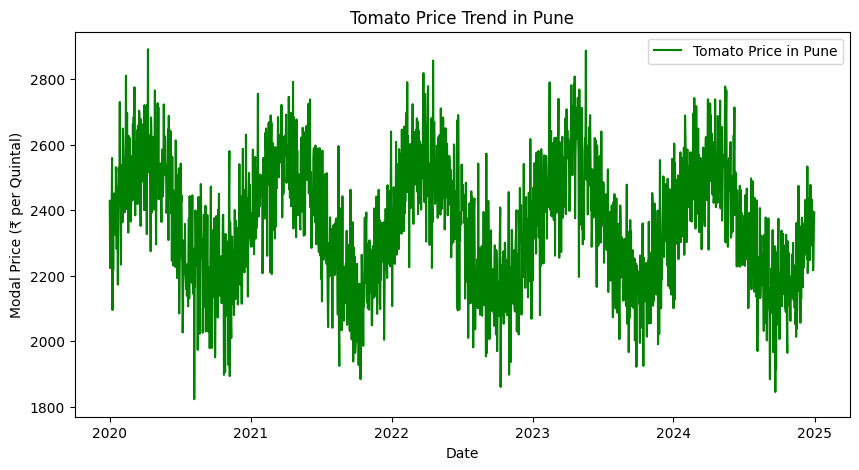

In [ ]:
# Data Preprocessing
# Filter by commodity and market (example: Tomato in Pune)
commodity = 'Tomato'
market = 'Pune'

data = df[(df['commodity'] == commodity) & (df['market'] == market)].copy()
data = data.sort_values('date')

plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['modal_price'], label=f'{commodity} Price in {market}', color='green')
plt.title(f'{commodity} Price Trend in {market}')
plt.xlabel('Date')
plt.ylabel('Modal Price (₹ per Quintal)')
plt.legend()
plt.show()



In [ ]:
# Prepare Data for LSTM
# Scale prices (LSTM works better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['modal_price']])

# Create time-series sequences
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(data_scaled, n_steps)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print("✅ Shape of X:", X.shape)
print("✅ Shape of y:", y.shape)


✅ Shape of X: (1797, 30, 1)
✅ Shape of y: (1797, 1)


In [ ]:
# Build LSTM Model

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\Pruthviraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0521 - val_loss: 0.0151
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0181 - val_loss: 0.0128
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0169 - val_loss: 0.0116
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0164 - val_loss: 0.0121
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0165 - val_loss: 0.0115
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0164 - val_loss: 0.0116
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 9/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0158 - val_loss: 0.0115
Epoch 10/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0154 - val_loss: 0.0116
Epoch 11/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0153 - val_loss: 0.0116
Epoch 12/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

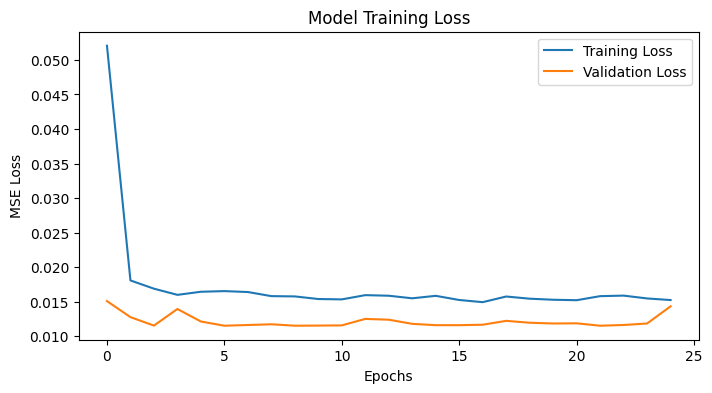

In [33]:
# Train the Model

history = model.fit(X, y, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()



57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ RMSE: 137.33, R²: 0.464


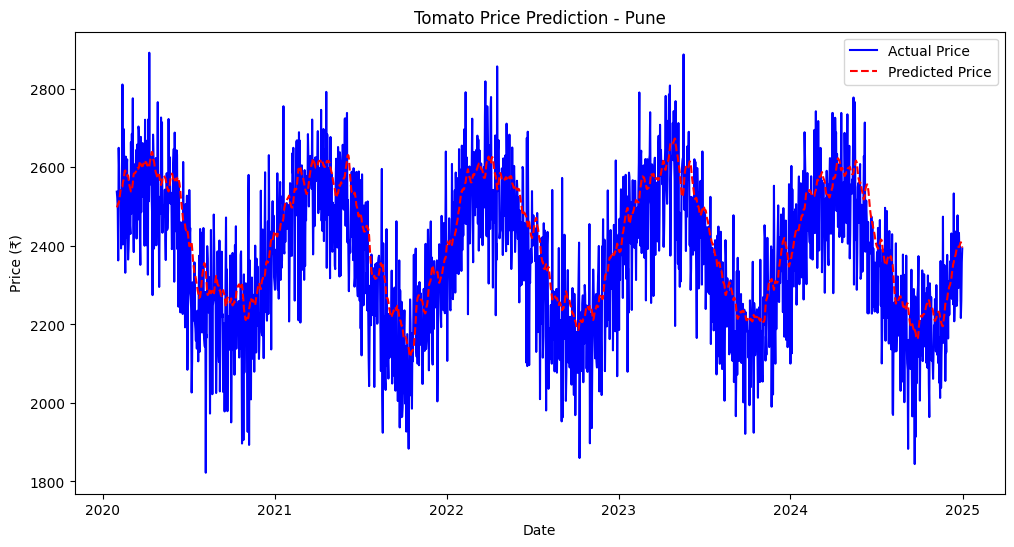

In [40]:
# Predict on training data

y_pred = model.predict(X)

# Inverse scale
y_true = scaler.inverse_transform(y)
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_true, y_pred_inv))
r2 = r2_score(y_true, y_pred_inv)
print(f"✅ RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(data['date'][n_steps:], y_true, label='Actual Price', color='blue')
plt.plot(data['date'][n_steps:], y_pred_inv, label='Predicted Price', color='red', linestyle='--')
plt.title(f'{commodity} Price Prediction - {market}')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


C:\Users\Pruthviraj\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129530 (\N{BASKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


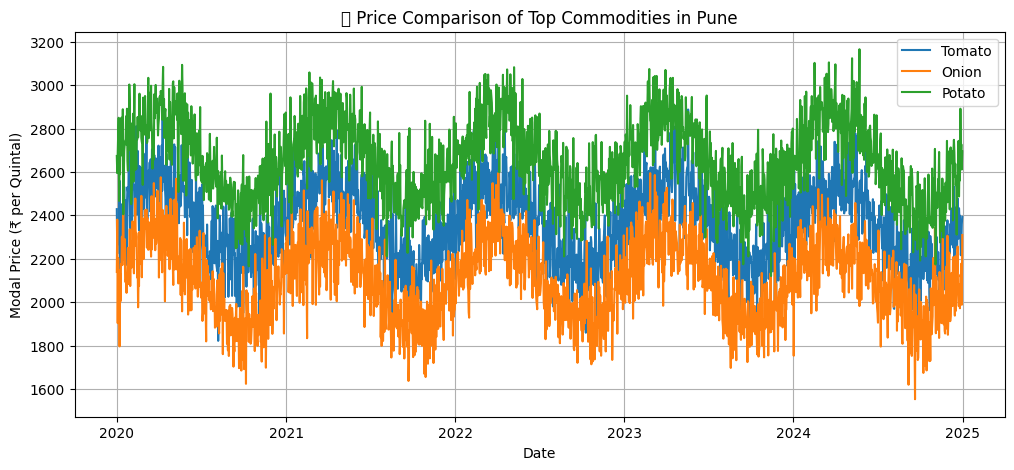

In [42]:


# Compare price trends of top commodities in one market
market = 'Pune'
top_commodities = df[df['market'] == market]['commodity'].value_counts().head(3).index

plt.figure(figsize=(12, 5))
for c in top_commodities:
    sub = df[(df['commodity'] == c) & (df['market'] == market)]
    plt.plot(sub['date'], sub['modal_price'], label=c)
plt.legend()
plt.title(f'🧺 Price Comparison of Top Commodities in {market}')
plt.xlabel('Date')
plt.ylabel('Modal Price (₹ per Quintal)')
plt.grid(True)
plt.show()




C:\Users\Pruthviraj\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


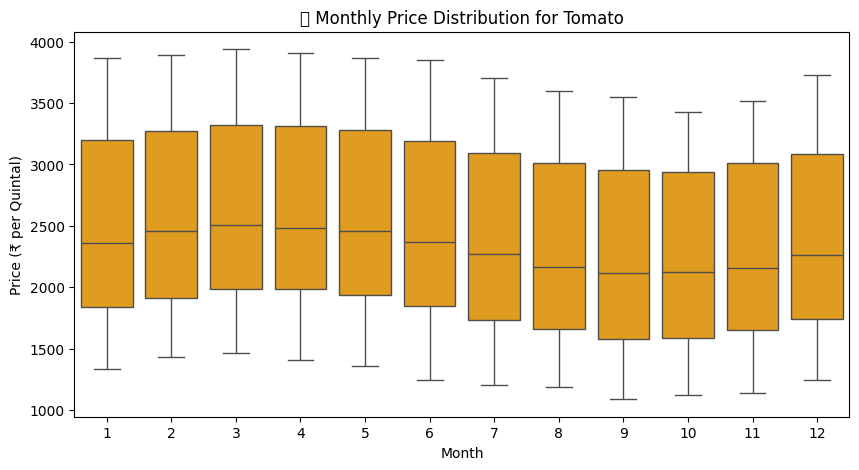

In [41]:
# Extract Month and Year for seasonal pattern
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

plt.figure(figsize=(10,5))
sns.boxplot(data=df[df['commodity'] == commodity], x='month', y='modal_price', color='orange')
plt.title(f'🌤 Monthly Price Distribution for {commodity}')
plt.xlabel('Month')
plt.ylabel('Price (₹ per Quintal)')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


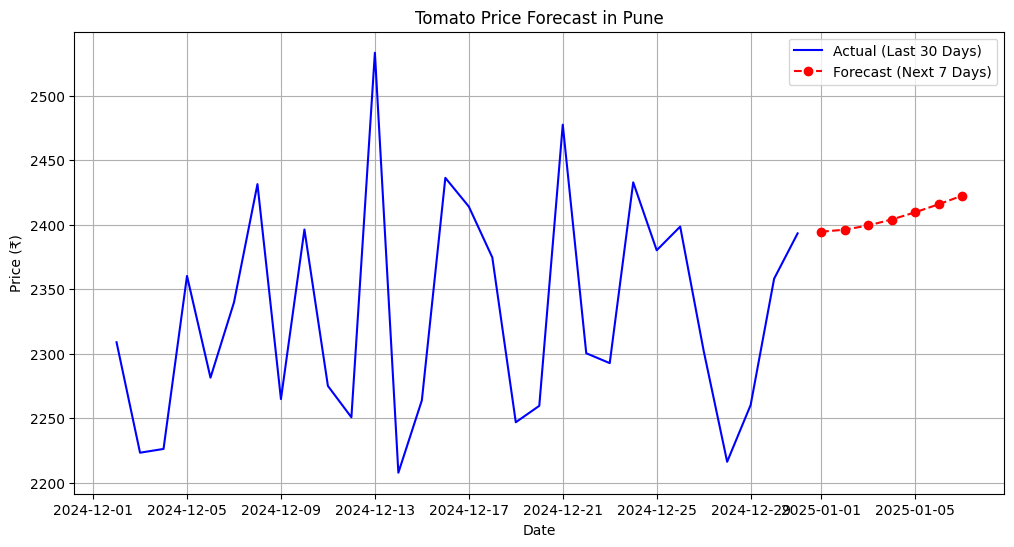

In [ ]:
# Forecast Future Prices

def predict_future(model, data_scaled, scaler, n_steps=30, days_ahead=7):
    last_seq = data_scaled[-n_steps:]
    preds = []

    for _ in range(days_ahead):
        X_input = last_seq.reshape((1, n_steps, 1))
        pred_scaled = model.predict(X_input)
        preds.append(pred_scaled[0][0])
        last_seq = np.append(last_seq[1:], pred_scaled)

    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    return preds_inv

# Forecast next 7 days
future_preds = predict_future(model, data_scaled, scaler, days_ahead=7)

# Create future dates
last_date = data['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=8, freq='D')[1:]

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(data['date'][-30:], data['modal_price'].iloc[-30:], label='Actual (Last 30 Days)', color='blue')
plt.plot(future_dates, future_preds, label='Forecast (Next 7 Days)', color='red', linestyle='--', marker='o')
plt.title(f'{commodity} Price Forecast in {market}')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Pruthviraj\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


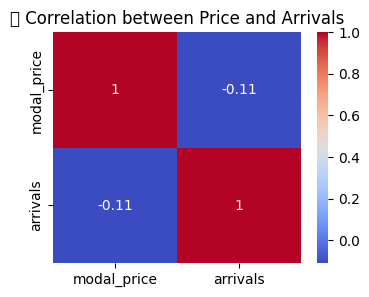

In [44]:
# correlation analysis

if 'arrivals' in df.columns:
    corr = df[['modal_price', 'arrivals']].corr()
    plt.figure(figsize=(4, 3))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('📊 Correlation between Price and Arrivals')
    plt.show()


In [45]:
# Summary Insight

print("✅ Model Trained and Forecast Completed Successfully!")
print(f"📈 {commodity} in {market} — Next 7 Days Predicted Prices:")
for i, price in enumerate(future_preds.flatten(), 1):
    print(f"Day {i}: ₹{price:.2f}")


✅ Model Trained and Forecast Completed Successfully!
📈 Tomato in Pune — Next 7 Days Predicted Prices:
Day 1: ₹2394.70
Day 2: ₹2396.25
Day 3: ₹2399.53
Day 4: ₹2404.11
Day 5: ₹2409.72
Day 6: ₹2415.93
Day 7: ₹2422.61
